In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from transit_periodogram.transit_periodogram import transit_periodogram

<Container object of 3 artists>

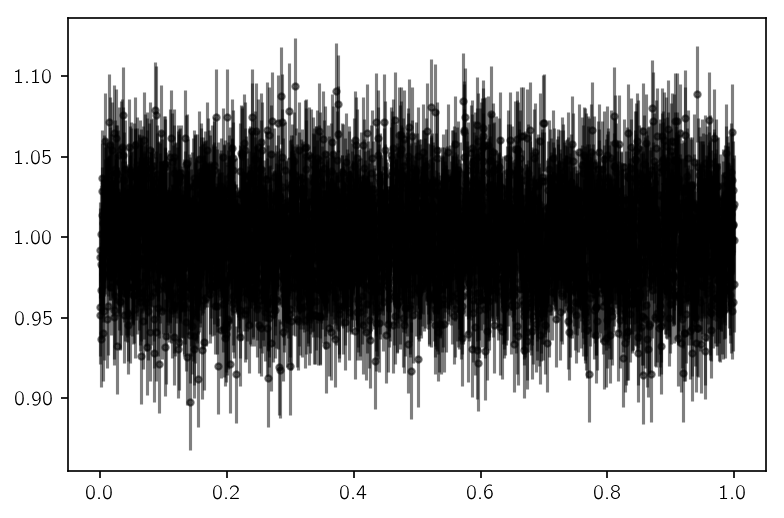

In [24]:
np.random.seed(41)

time = np.linspace(0, 60, 3000)

flux_err = 0.03 + np.zeros_like(time)
period = 2

transit_depth = 0.01
transit_duration = 0.125
transit_time = 2.5

flux = np.ones_like(time)
# flux[np.abs((time - transit_time + 0.5*period) % period - 0.5*period) < 0.5*transit_duration] = 1.0 - transit_depth

flux += flux_err * np.random.randn(len(flux))

plt.errorbar((time%period)/period, flux, yerr=flux_err, fmt=".k", alpha=0.5)
# plt.xlim(0, );

In [25]:
df = 0.5 / (time.max() - time.min())
fmax = 0.1 / np.median(np.diff(time))
freq = np.arange(10*df, fmax, 0.02*df)
periods = 1.0 / freq
len(freq)

29491

In [26]:
periodogram, depth, depth_err, phase, duration, depth_snr, log_likelihood = \
    transit_periodogram(time, flux, periods, transit_duration, flux_err=flux_err)
ind = np.argmax(periodogram)
periods[ind], phase[ind], (transit_time)%period

(2.0942408376963817, 1.175, 0.5)

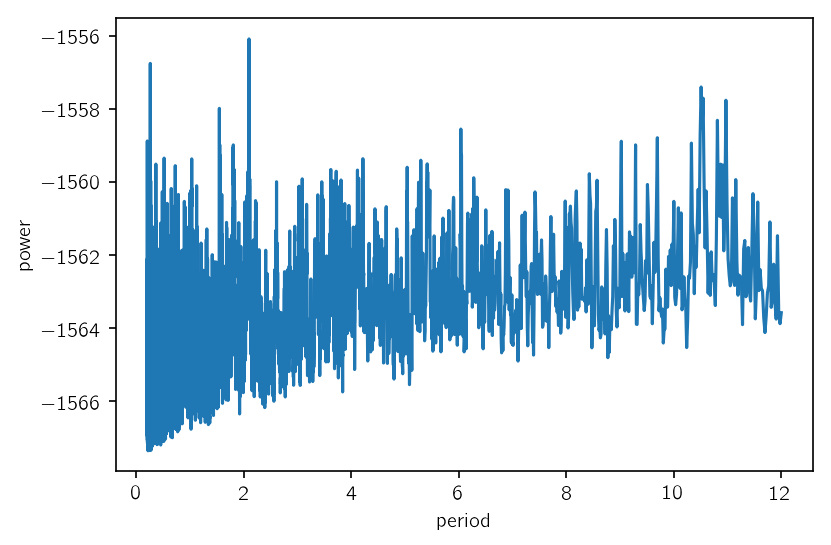

In [27]:
plt.plot(periods, periodogram)
plt.xlabel("period")
plt.ylabel("power");

In [28]:
periodogram, depth, depth_err, phase, duration, depth_snr, log_likelihood = \
    transit_periodogram(time, flux, periods, transit_duration,
                        flux_err=flux_err, method="snr")

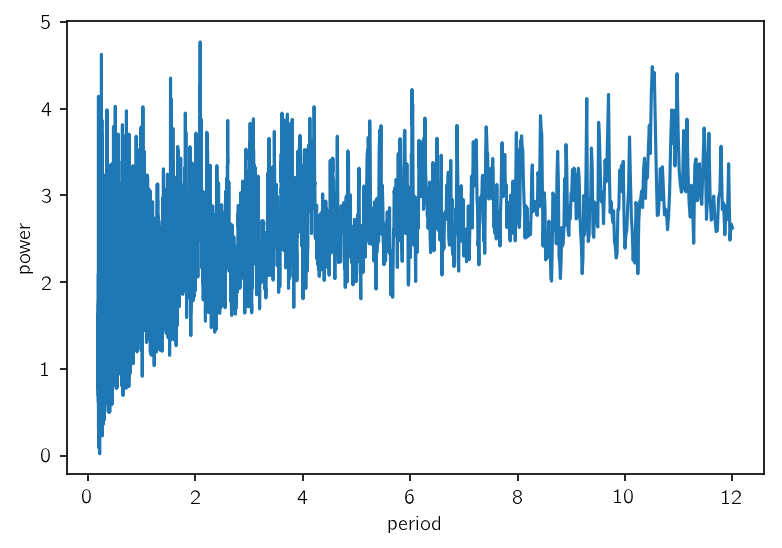

In [29]:
plt.plot(periods, periodogram)
plt.xlabel("period")
plt.ylabel("power");

In [32]:
import bls

In [33]:
%%timeit
u = np.empty_like(time)
v = np.empty_like(time)
nf = len(freq)
fmin = np.min(freq)
df = freq[1] - freq[0]
nb = 400
qmi = transit_duration/period
qma = transit_duration/period
results = bls.eebls(time, flux, u, v, nf, fmin, df, nb, qmi, qma)

1 loop, best of 3: 467 ms per loop


In [34]:
%%timeit
transit_periodogram(time, flux, periods, transit_duration, flux_err=flux_err)

1 loop, best of 3: 374 ms per loop
